[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/tv_minimization_reconstruction_pdhg.ipynb)

In [20]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebooks]

In [21]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [22]:
import torch

device = 'cuda:0'
torch.set_default_device(device)

# Total-variation (TV)-minimization reconstruction

### Image reconstruction
Here, we use the Primal Dual Hybrid Gradient (PDHG) algorithm to reconstruct an image from 2D radial k-space data.

Let $y$ denote the k-space data of the image $x_{\mathrm{true}}$ sampled with an acquisition model $A$
(Fourier transform, coil sensitivity maps, ...), i.e the forward problem is given as

$ y = Ax_{\mathrm{true}} + n, $

where $n$ describes complex Gaussian noise. When using TV-minimization as regularization method, an approximation of
$x_{\mathrm{true}}$ is obtained by minimizing the following functional $\mathcal{F}$ where $\nabla$ is the
discretized gradient operator.

$ \mathcal{F}(x) = \frac{1}{2}||Ax - y||_2^2 + \lambda \| \nabla x \|_1, \quad \quad \quad (1)$

The minimization of the functional $\mathcal{F}$ is a non-trivial task due to the presence of the operator
$\nabla$ in the non-differentiable $\ell_1$-norm. A suitable algorithm to solve the problem is the
PDHG-algorithm [[Chambolle \& Pock, JMIV 2011](https://doi.org/10.1007%2Fs10851-010-0251-1)].\
PDHG is a method for solving problems of the form

$ \min_x f(K(x)) + g(x)  \quad \quad \quad (2)$

where $f$ and $g$ denote proper, convex, lower-semicontinous functionals and $K$ denotes a linear operator.\
PDHG essentially consists of three steps, which read as

$z_{k+1} = \mathrm{prox}_{\sigma f^{\ast}}(z_k + \sigma K \bar{x}_k)$

$x_{k+1} = \mathrm{prox}_{\tau g}(x_k - \tau K^H z_{k+1})$

$\bar{x}_{k+1} = x_{k+1} + \theta(x_{k+1} - x_k)$,

where $\mathrm{prox}$ denotes the proximal operator and $f^{\ast}$ denotes the convex conjugate of the
functional $f$, $\theta\in [0,1]$ and step sizes $\sigma, \tau$ such that $\sigma \tau < 1/L^2$, where
$L=\|K\|_2$ is the operator norm of the operator $K$.

The first step is to recast problem (1) into the general form of (2) and then to apply the steps above
in an iterative fashion. In the following, we use this approach to reconstruct a 2D radial image using
`~mrpro.algorithms.optimizers.pdhg`.

### Load data
Our example data contains three scans acquired with a 2D golden angle radial trajectory and
varying number of spokes:

- ``radial2D_24spokes_golden_angle_with_traj.h5``
- ``radial2D_96spokes_golden_angle_with_traj.h5``
- ``radial2D_402spokes_golden_angle_with_traj.h5``

We will use the 402 spokes as a reference and try to reconstruct the image from the 24 spokes data.

In [23]:
# # Download raw data from Zenodo
# import tempfile
# from pathlib import Path

# import zenodo_get

# tmp = tempfile.TemporaryDirectory()  # RAII, automatically cleaned up
# data_folder = Path(tmp.name)
# zenodo_get.download(record='14617082', retry_attempts=5, output_dir=data_folder)

In [24]:
import mrpro

# # We have embedded the trajectory information in the ISMRMRD files.
# kdata_402spokes = mrpro.data.KData.from_file(
#     data_folder / 'radial2D_402spokes_golden_angle_with_traj.h5', mrpro.data.traj_calculators.KTrajectoryIsmrmrd()
# )
# kdata_24spokes = mrpro.data.KData.from_file(
#     data_folder / 'radial2D_24spokes_golden_angle_with_traj.h5', mrpro.data.traj_calculators.KTrajectoryIsmrmrd()
# )

### Comparison reconstructions
Before running the TV-minimization reconstruction, we first run a direct (adjoint) reconstruction
using `~mrpro.algorithms.reconstruction.DirectReconstruction` (see <project:direct_reconstruction.ipynb>)
of both the 24 spokes and 402 spokes data to have a reference for comparison.

In [25]:
# direct_reconstruction_402 = mrpro.algorithms.reconstruction.DirectReconstruction(kdata_402spokes)
# direct_reconstruction_24 = mrpro.algorithms.reconstruction.DirectReconstruction(kdata_24spokes)
# img_direct_402 = direct_reconstruction_402(kdata_402spokes)
# img_direct_24 = direct_reconstruction_24(kdata_24spokes)

We also run an iterative SENSE reconstruction (see <project:iterative_sense_reconstruction_radial2D.ipynb>) with early
stopping of the 24 spokes data. We use it as a comparison and as an initial guess for the TV-minimization
reconstruction.

In [26]:
# sense_reconstruction = mrpro.algorithms.reconstruction.IterativeSENSEReconstruction(
#     kdata_24spokes,
#     n_iterations=8,
#     csm=direct_reconstruction_24.csm,
#     dcf=direct_reconstruction_24.dcf,
# )
# img_sense_24 = sense_reconstruction(kdata_24spokes)

### Set up the operator $A$
Now, to set up the problem, we need to define the acquisition operator $A$, consisting of a
`~mrpro.operators.FourierOp` and a `~mrpro.operators.SensitivityOp`, which applies the coil sensitivity maps
(CSM) to the image. We reuse the CSMs estimated in the direct reconstruction.

torch.Size([1, 1, 128, 128])
Range: 0.05882353335618973 to 0.9803922176361084


/tmp/ipykernel_1613413/4100306435.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  afm = cm.get_cmap('afmhot')


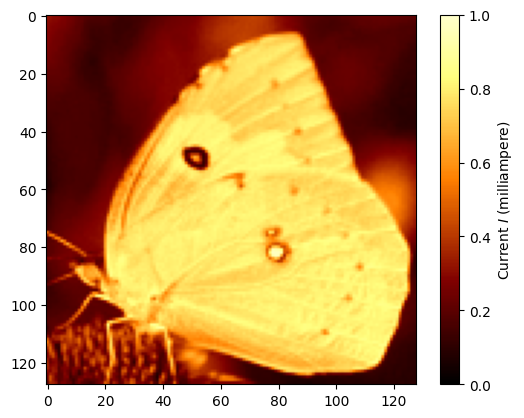

In [27]:
from PIL import Image
from torchvision.transforms import PILToTensor

J = 7
N = 1 << J

im_path = "Image_6.jpg"
im_pil = Image.open(im_path).convert('L')  # Shape 670 x 703
height, width = im_pil.size
im_pil = im_pil.resize((N, N))  # Resize to 512 x 512
# im_pil = im_pil.crop((height - 512, 0, height, 512))  # Crop to 512 x 512
im_tensor = PILToTensor()(im_pil).unsqueeze(0) / 255  # (1,1,H,W)
print(im_tensor.shape)
print(f'Range: {im_tensor.min().item()} to {im_tensor.max().item()}')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

# from matplotlib.colors import LinearSegmentedColormap
# # tweak the hex stops to taste
# stops = [
#     (0.00, "#000000"),
#     (0.08, "#140000"),  # near-black red
#     (0.20, "#3b0000"),  # very dark red
#     (0.35, "#6e0000"),  # deep red
#     (0.55, "#8a2616"),  # red-brown
#     (0.72, "#b45629"),  # brownish-orange
#     (0.86, "#d6a84a"),  # golden
#     (1.00, "#fff176"),  # light yellow (no white)
# ]
# cmap = LinearSegmentedColormap.from_list("black_red_to_yellow", stops, N=256)

data_minmax = (0.0, 1.0)


# take only the lower 0–90% of afmhot to avoid the white top
afm = cm.get_cmap('afmhot')
cmap = ListedColormap(afm(np.linspace(0.0, 0.90, 256)))

import matplotlib.pyplot as plt
plt.imshow(im_tensor.squeeze().cpu(), cmap=cmap, clim=data_minmax)
plt.colorbar(label=r'Current $I$ (milliampere)')

In [28]:
# # fourier_operator = mrpro.operators.FourierOp.from_kdata(kdata_24spokes)

# # assert direct_reconstruction_24.csm is not None
# # csm_operator = direct_reconstruction_24.csm.as_operator()

# # The acquisition operator is the composition of the Fourier operator and the CSM operator
# # acquisition_operator = fourier_operator @ csm_operator

from PCMOp import PCMOp
from LION.operators.PhotocurrentMapOp import Subsampler
# J = 9  # 512x512 images
# N = 1 << J

# # sino, target = dataset[0]
# # im_tensor = target.unsqueeze(0)  # (1,1,H,W)

subtract_from_J = 1
delta_divided_by = 4

coarseJ = J - subtract_from_J
delta = 1.0 / delta_divided_by

# sampling_rate_percent = delta * 100
# in_order_measurements_percent = 1 / (1 << (subtract_from_J * 2)) * 100

subsampler = Subsampler(n=N * N, coarseJ=coarseJ, delta=delta)
acquisition_operator = PCMOp(J=J, subsampler=subsampler)

/tmp/ipykernel_1613413/1303389275.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  afm = cm.get_cmap('afmhot')


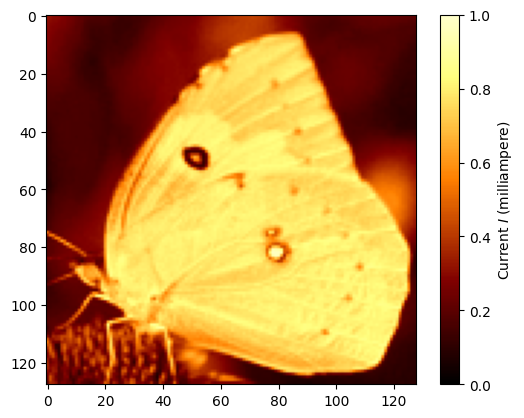

In [29]:
from PIL import Image
from torchvision.transforms import PILToTensor

# im_path = 'sample.png'
# im_pil = Image.open(im_path).convert('L')  # Shape 670 x 703
# height, width = im_pil.size
# im_pil = im_pil.resize((512, 512))  # Resize to 512 x 512
# # im_pil = im_pil.crop((height - 512, 0, height, 512))  # Crop to 512 x 512
# im_tensor = PILToTensor()(im_pil).unsqueeze(0).unsqueeze(0) / 255  # (1,1,H,W)
# print(im_tensor.shape)
# print(f'Range: {im_tensor.min().item()} to {im_tensor.max().item()}')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

# from matplotlib.colors import LinearSegmentedColormap
# # tweak the hex stops to taste
# stops = [
#     (0.00, "#000000"),
#     (0.08, "#140000"),  # near-black red
#     (0.20, "#3b0000"),  # very dark red
#     (0.35, "#6e0000"),  # deep red
#     (0.55, "#8a2616"),  # red-brown
#     (0.72, "#b45629"),  # brownish-orange
#     (0.86, "#d6a84a"),  # golden
#     (1.00, "#fff176"),  # light yellow (no white)
# ]
# cmap = LinearSegmentedColormap.from_list("black_red_to_yellow", stops, N=256)

data_minmax = (0.0, 1.0)


# take only the lower 0–90% of afmhot to avoid the white top
afm = cm.get_cmap('afmhot')
cmap = ListedColormap(afm(np.linspace(0.0, 0.90, 256)))

import matplotlib.pyplot as plt
plt.imshow(im_tensor.squeeze().cpu(), cmap=cmap, clim=data_minmax)
plt.colorbar(label=r'Current $I$ (milliampere)')

y_subsampled_tensor = acquisition_operator(im_tensor)[0]
im_reconstructed_tensor = acquisition_operator.adjoint(y_subsampled_tensor)[0]

/tmp/ipykernel_1613413/2231931775.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


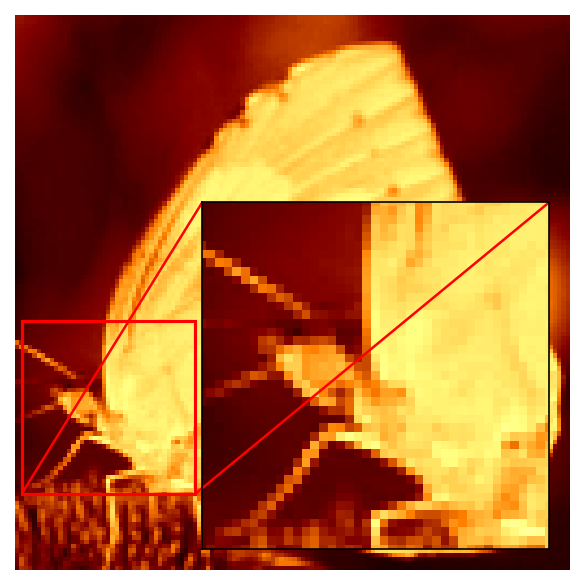

In [40]:
from plot_helper import PlotHelper


# Dummy image
# img = np.random.rand(512, 512)
img = im_tensor.squeeze().cpu().numpy()
roi = (1, 70, 40, 40)  # (x, y, w, h)
zoom = 2
plot_helper = PlotHelper(roi=roi, zoom=zoom, loc='lower right', show_rect=True, cmap=cmap, clim=data_minmax)

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
plot_helper.add_zoom_inset(ax, img)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1613413/2555878089.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


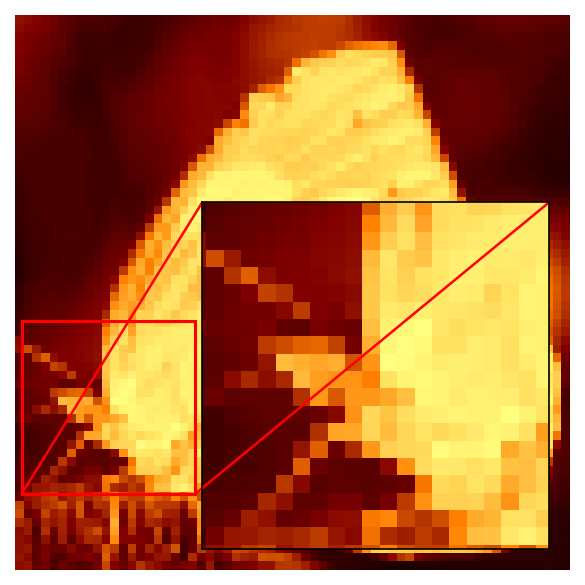

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
plot_helper.add_zoom_inset(ax, im_reconstructed_tensor.squeeze().cpu().numpy())
plt.tight_layout()
plt.show()

### Recast the problem to be able to apply PDHG
To apply the PDHG algorithm, we need to recast the problem into the form of (2). We need to identify
the functionals $f$ and $g$ and the operator $K$. We chose an identification for which both
$\mathrm{prox}_{\sigma f^{\ast}}$ and $\mathrm{prox}_{\tau g}$ are easy to compute:

#### $f(z) = f(p,q) = f_1(p) + f_2(q) =  \frac{1}{2}\|p  - y\|_2^2 + \lambda \| q \|_1.$

In [58]:
# regularization_lambda = 0.2
regularization_lambda = 0.1
# f_1 = 0.5 * mrpro.operators.functionals.L2NormSquared(target=kdata_24spokes.data, divide_by_n=True)
f_1 = 0.5 * mrpro.operators.functionals.L2NormSquared(target=y_subsampled_tensor, divide_by_n=True)
f_2 = regularization_lambda * mrpro.operators.functionals.L1NormViewAsReal(divide_by_n=True)
f = mrpro.operators.ProximableFunctionalSeparableSum(f_1, f_2)

#### $K(x) = [A, \nabla]^T$

  where $\nabla$ is the finite difference operator that computes the directional derivatives along the last two
  dimensions (y,x), implemented as `~mrpro.operators.FiniteDifferenceOp`, and
 `~mrpro.operators.LinearOperatorMatrix` can be used to stack the operators.

In [59]:
# nabla = mrpro.operators.FiniteDifferenceOp(dim=(-2, -1), mode='forward')
nabla = mrpro.operators.FiniteDifferenceOp(dim=(-1,), mode='forward')
K = mrpro.operators.LinearOperatorMatrix(((acquisition_operator,), (nabla,)))

#### $g(x) = 0,$

implemented as `~mrpro.operators.functionals.ZeroFunctional`

In [60]:
g = mrpro.operators.functionals.ZeroFunctional()

```{note}
An obvious identification would have been
- $f(x) = \lambda \| x\|_1,$
- $g(x) = \frac{1}{2}\|Ax  - y\|_2^2,$
- $K(x) = \nabla x.$

But to be able to compute $\mathrm{prox}_{\tau g}$, one would need to solve a linear system at each
iteration, making this identification impractical.
```

This identification allows us to compute the proximal operators of $f$ and $g$ easily.
### Run PDHG for a certain number of iterations
Now we can run the PDHG algorithm to solve the minimization problem. We use
the iterative SENSE image as an initial value to speed up the convergence.
```{note}
We can use the `callback` parameter of `~mrpro.algorithms.optimizers` to get some information
about the progress. In the collapsed cell, we implement a simple callback function that print the status
message
```

In [61]:
# This is a "callback" function that will be called after each iteration of the PDHG algorithm.
# We use it here to print progress information.

from mrpro.algorithms.optimizers.pdhg import PDHGStatus


def callback(optimizer_status: PDHGStatus) -> None:
    """Print the value of the objective functional every 16th iteration."""
    iteration = optimizer_status['iteration_number']
    solution = optimizer_status['solution']
    if iteration % 16 == 0:
        print(f'Iteration {iteration: >3}: Objective = {optimizer_status["objective"](*solution).item():.3e}')

In [62]:
(img_pdhg_24,) = mrpro.algorithms.optimizers.pdhg(
    f=f,
    g=g,
    operator=K,
    # initial_values=(img_sense_24.data,),
    initial_values=(im_reconstructed_tensor,),
    # max_iterations=257,
    max_iterations=513,
    callback=callback,
)

Iteration   0: Objective = 1.961e-03
Iteration  16: Objective = 1.959e-03
Iteration  32: Objective = 1.958e-03
Iteration  48: Objective = 1.956e-03
Iteration  64: Objective = 1.955e-03
Iteration  80: Objective = 1.953e-03
Iteration  96: Objective = 1.952e-03
Iteration 112: Objective = 1.951e-03
Iteration 128: Objective = 1.949e-03
Iteration 144: Objective = 1.948e-03
Iteration 160: Objective = 1.946e-03
Iteration 176: Objective = 1.945e-03
Iteration 192: Objective = 1.944e-03
Iteration 208: Objective = 1.942e-03
Iteration 224: Objective = 1.941e-03
Iteration 240: Objective = 1.940e-03
Iteration 256: Objective = 1.938e-03
Iteration 272: Objective = 1.937e-03
Iteration 288: Objective = 1.936e-03
Iteration 304: Objective = 1.934e-03
Iteration 320: Objective = 1.933e-03
Iteration 336: Objective = 1.932e-03
Iteration 352: Objective = 1.931e-03
Iteration 368: Objective = 1.929e-03
Iteration 384: Objective = 1.928e-03
Iteration 400: Objective = 1.927e-03
Iteration 416: Objective = 1.926e-03
I

### Compare the results
We now compare the results of the direct reconstruction, the iterative SENSE reconstruction, and the TV-minimization

In [63]:
import matplotlib.pyplot as plt
import torch


def show_images(*images: torch.Tensor, titles: list[str] | None = None) -> None:
    """Plot images."""
    n_images = len(images)
    _, axes = plt.subplots(1, n_images, squeeze=False, figsize=(n_images * 3, 3))
    for i in range(n_images):
        axes[0][i].imshow(images[i], cmap='gray')
        axes[0][i].axis('off')
        if titles:
            axes[0][i].set_title(titles[i])
    plt.show()

/tmp/ipykernel_1613413/1053449429.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


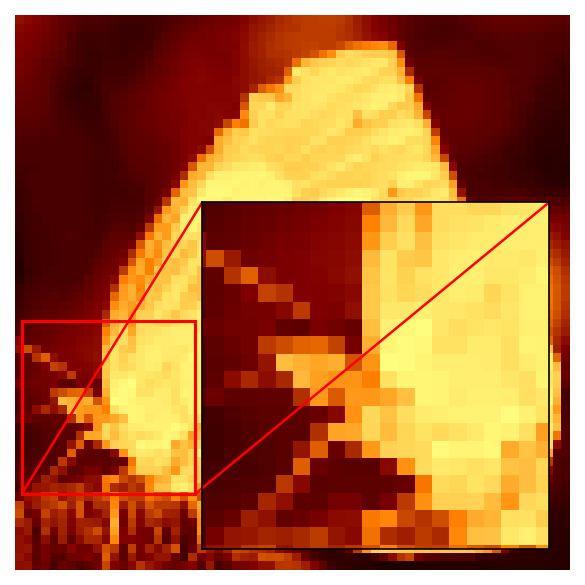

In [64]:
# # see the collapsed cell above for the implementation of show_images
# show_images(
#     img_direct_402.rss().squeeze(),
#     img_direct_24.rss().squeeze(),
#     img_sense_24.rss().squeeze(),
#     img_pdhg_24.abs().squeeze(),
#     titles=['402 spokes', '24 spokes (direct)', '24 spokes (SENSE)', '24 spokes (PDHG)'],
# )

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
plot_helper.add_zoom_inset(ax, img_pdhg_24.squeeze().cpu().numpy())
plt.tight_layout()
plt.show()

/tmp/ipykernel_1613413/2555878089.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


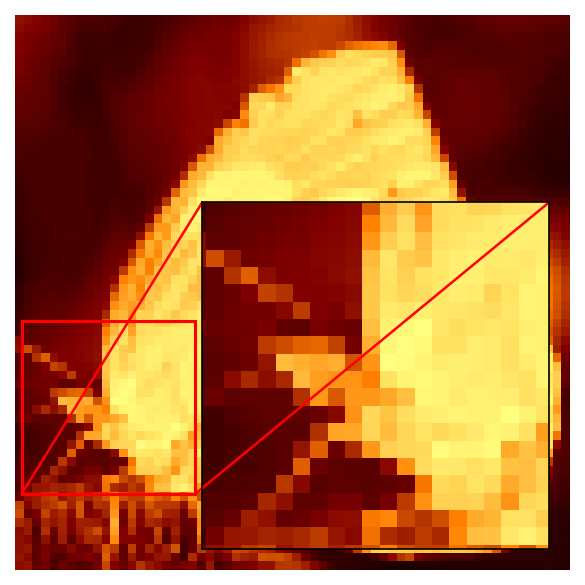

In [65]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
plot_helper.add_zoom_inset(ax, im_reconstructed_tensor.squeeze().cpu().numpy())
plt.tight_layout()
plt.show()

Hurrah! We have successfully reconstructed an image from 24 spokes using TV-minimization.

### Next steps
Play around with the regularization weight and the number of iterations to see how they affect the final image.
You can also try to use the 96 spokes data to see how the reconstruction quality improves with more spokes.